Here, we aim to quantify feature importance -- which features are we using the most to come to predictions? We do this via random forest mean decrease in impurity, as well as SHAP.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import shap

In [ ]:
# We get the data from file
df = pd.read_csv('compiled_datasets/nanotox_features_dataset.csv')
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)
attr_names = df.columns[1:-1].values

In [ ]:
# Import and train the Random forest, get MDI feature importance metric
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X, y)
imp = rf.feature_importances_

In [ ]:
# Re-sort and re-group the features for visualization
# For instance, due to OH encoding, NP Type is separated into multiple features. We aggregate them into a single group here.
features_split = np.array([i.split('_')[0].replace(' (categorical)', '') for i in attr_names])
feature_names = np.unique(features_split)

# We sum the MDI scores per each group
fimp = np.array([imp[features_split == f].sum() for f in feature_names])

In [81]:
feature_names

array(['Aggregation', 'Assay', 'Cell name', 'Cell origin (anatomical)',
       'Cell origin (organ)', 'Cell origin (primary or cell-line)',
       'Cell origin (species)', 'Dose', 'Electronegativity',
       'Exposure time', 'Hydrodynamic size', 'Ionic radius',
       'Molecular weight', 'NP Type', 'QD Concentration', 'QD Core',
       'QD Emission wavelength', 'QD Shell', 'QD Surface ligand', 'Shape',
       'Size', 'Surface area', 'Surface charge', 'Surface coating',
       'Surface reactivity', 'Zeta potential'], dtype='<U34')

In [88]:
# Rename the features for visualization
feature_names_display = np.array([
    {
        'Aggregation': 'Aggregation',
        'Assay': 'Assay',
        'Cell name': 'Cell name',
        'Cell origin (anatomical)': 'Cell type',
        'Cell origin (organ)': 'Cell organ',
        'Cell origin (primary or cell-line)': 'Primary vs. Cell-line',
        'Cell origin (species)': 'Cell species',
        'Dose': 'Dose (µg/kg)',
        'Electronegativity': 'Electronegativity',
        'Exposure time': 'Exposure time (hr)',
        'Hydrodynamic size': 'Hydrodynamic diameter (nm)',
        'Ionic radius': 'Ionic radius (pm)',
        'Molecular weight': 'Molecular weight (g/mol)',
        'NP Type': 'NP Type',
        'QD Concentration': 'Concentration (nmol)',
        'QD Core': 'QD Core',
        'QD Emission wavelength': 'Emission wavelength (nm)',
        'QD Shell': 'QD Shell',
        'QD Surface ligand': 'Surface ligand',
        'Shape': 'Shape',
        'Size': 'Diameter (nm)',
        'Surface area': 'Surface area (nm$^2$)',
        'Surface charge': 'Surface charge',
        'Surface coating': 'Surface coating',
        'Surface reactivity': 'Surface reactivity',
        'Zeta potential': 'Zeta potential (mV)',

    }.get(f, f)
    for f in feature_names
])

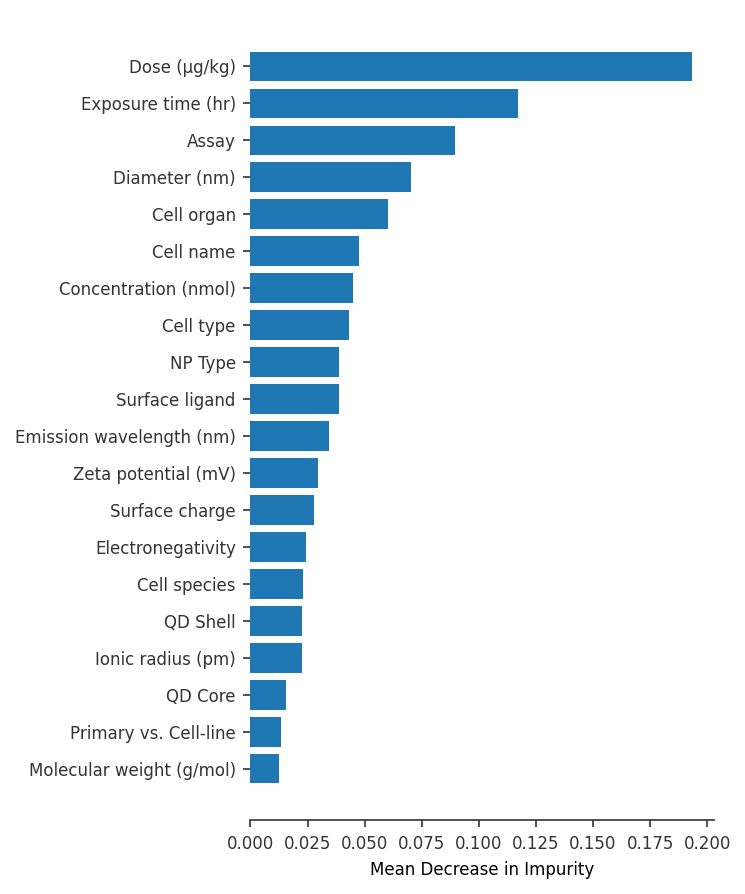

In [89]:
# Here we plot the 20 highest MDI scores of our features

# Change display parameters, so plot looks similar to the SHAP plot below
COLOR = '#343434'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.left'] = False
matplotlib.rcParams['axes.spines.top'] = False

# We sort the MDI scores (fimp) and
plt.figure(figsize=(5, 6), dpi=150)
ord = np.argsort(-fimp)[:20][::-1]  # Get order of the featured, based on MDI

# Plot the data and add labels
plt.barh( feature_names_display[ord], fimp[ord])
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.savefig('figures/mdi.png')
plt.show()

In [ ]:
# Here, we run SHAP algorithm in batches of 10 samples

explainer = shap.TreeExplainer(rf)
# This `idx` is not necessary unless we are only sampling a fraction of the data:
idx = np.random.choice(np.arange(X.shape[0]), size=(X.shape[0],), replace=False)
explainers = []
for i in range(0, X.shape[0], 10):
    print(f'{i}/{X.shape[0]}')
    explainers.append(explainer(X[i:i + 10]))  # This line generates the SHAP values

# Aggregate the batches
shap_values = np.concatenate([i.values for i in explainers])

In [ ]:
# Similarly to MDI, we aggregate the shapley values into feature groups
# As SHAP values are additive, this is statistically allowable

restrained_shap_values = []
for f in feature_names:
    mask = features_split == f
    restrained_shap_values.append(shap_values[:, mask, :].sum(axis=1))
restrained_shap_values = np.array(restrained_shap_values)
restrained_shap_values = restrained_shap_values.transpose((1, 0, 2))

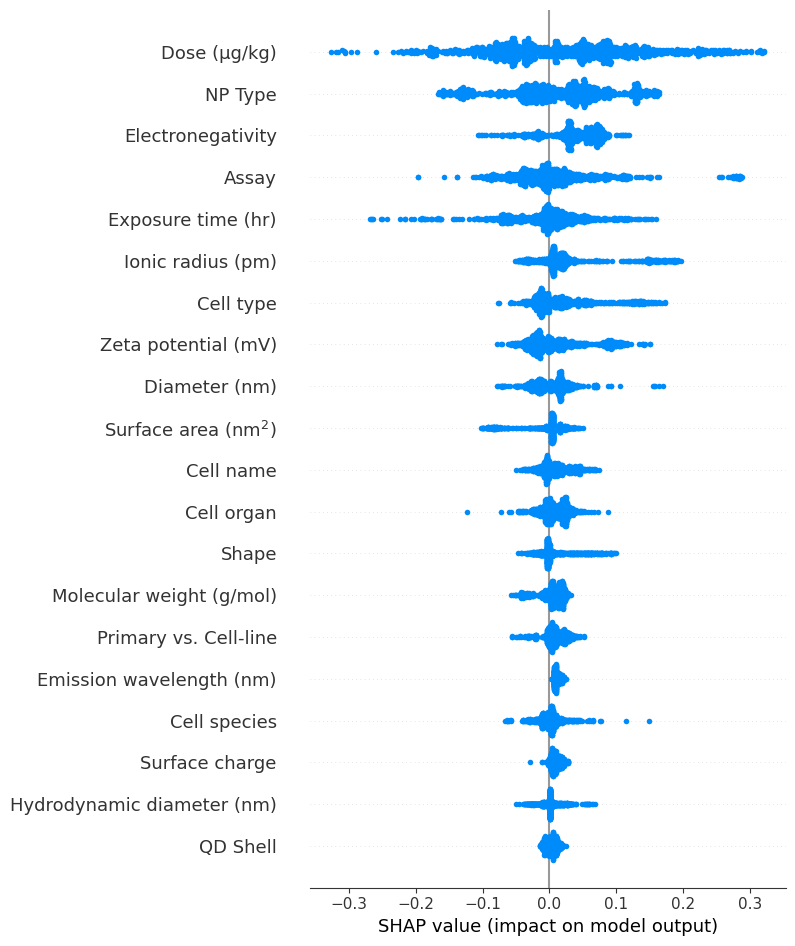

In [90]:
# We plot the figure here, using the `shap` library's built-in plot
plt.figure(figsize=(5, 6), dpi=100)
shap.summary_plot(shap_values=restrained_shap_values[:, :, 1], feature_names=feature_names_display, show=False)
plt.tight_layout()
plt.savefig('figures/shap.png')
plt.show()